# Loop over multiple SIR 3S calculations

This example demonstrates how to loop over several SIR 3S calculations, calculate each different state and plot it.

SIR 3S provides a C# .NET adapter for carrying out loops over multiple calculations. With the C# .NET adapter, SIR 3S calculations can be integrated directly into other software. In SIR 3S itself, the C# .NET adapter is used to implement calculation loops such as n-1 calculations.

In addition, SIR 3S provides connections to control systems via OPC and other interfaces such as Kafka. The SIR 3S software component for these connections is called - for historical reasons - SirOPC. SirIPC (Inter Process Communication) is a more suitable name for SirOPC. SirOPC is used for e.g. control system integrated SIR 3S simulations such as cyclic look-ahead calculations.

Regardless of the topic of interprocess communication SIR 3S offers the option to perform several steady state calculations one after the other in one SIR 3S calculation run as quasi steady state calculations. The sequence of calculations is done out over a pseudo time step, e.g. 1 hour with 60 calculations or 1 year with 8760 calculations. Whether individual calculations or a sequence over a pseudo-time in one run is the better choice depends on the task.

Despite the aforementioned options, it can be helpful to control or perform SIR 3S calculations calculations by script.

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Necessary packages for this Example

In [2]:
pip install -q ipywidgets folium ipython

Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import os
import geopandas
import logging
import pandas as pd
import io
import subprocess
import numpy as np
#from PIL import Image

import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
#import matplotlib.dates as mdates

import matplotlib

import folium
from folium.plugins import HeatMap

import networkx as nx

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts
    
try:
    from PT3S import Mx
except:
    import Mx

try:
    from PT3S import Rm
except:
    import Rm
    
    
try:
    from PT3S import pNFD
except:
    import pNFD

try:
    from PT3S import ncd
except:
    import ncd

In [4]:
import importlib

In [5]:
#importlib.reload(dxAndMxHelperFcts)

# Logging

In [6]:
logger = logging.getLogger()  

logFileName= r"Example5.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [7]:
dbFilename="Example5"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [8]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile,preventPklDump=True,maxRecords=-1)

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example5.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\Example5.db3 is newer than
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.XML is newer than
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MX1:
+SirCalc's xmlFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; dxAndMxHelperFcts.readDxAndMx: running C:\\3S\SIR 3S\SirCalc-90-14-02-10_Potsdam\SirCalc.exe ...
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


# Plot Result 

## As Network Color Diagram

In [9]:
def plot_Result_ncd(gdf_ROHR, gdf_FWVB, axTitle='initial condition'):
    
    fig, ax = plt.subplots(figsize=Rm.DINA3q)
        
    nodes_patches_1 = ncd.pNcd_nodes(ax=ax
                                    ,gdf=gdf_FWVB
                                    ,attribute='QM'
                                    ,colors = ['cyan','teal'] 
                                    ,norm_max=100
                                    ,marker_style='p'
                                    ,legend_fmt = '{:4.0f} t/h'
                                    ,legend_values = [0,25,50,75,100]
                                    ,zorder=1)

    pipes_patches_2 = ncd.pNcd_pipes(ax=ax
                                     ,gdf=gdf_ROHR
                                     ,attribute='DI'                        
                                     ,colors = ['lightgray', 'dimgray']
                                     ,legend_fmt = '{:4.0f} mm'
                                     ,line_width_factor=20
                                     ,legend_values = [0,250,500,750]
                                     ,zorder=2)
                            
    
    pipes_patches_3 = ncd.pNcd_pipes(ax=ax
                                     ,gdf=gdf_ROHR
                                     ,attribute='QMAVAbs'
                                     ,colors = ['darkgreen', 'magenta']
                                     ,legend_fmt = '{:4.0f} t/h'
                                     ,line_width_factor=20
                                     ,legend_values = [0,500,1000,1500,2000]
                                     ,zorder=3)    
    all_patches = nodes_patches_1 + pipes_patches_2 + pipes_patches_3
    ax.legend(handles=all_patches, loc='best')
    
    plt.title(axTitle)
    plt.show()

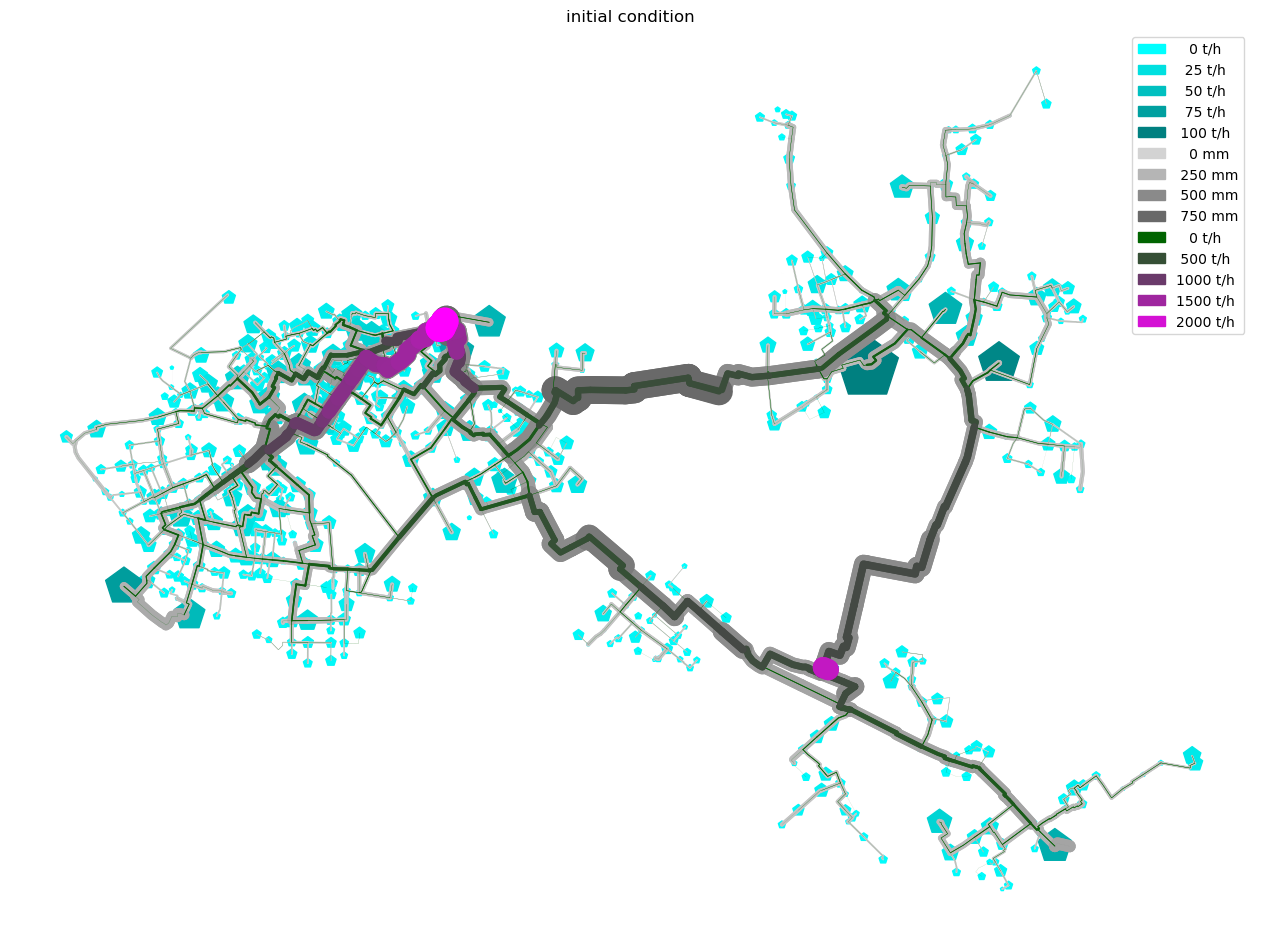

In [10]:
plot_Result_ncd(m.gdf_ROHR, m.gdf_FWVB)

## Longitudinal Sections

In [11]:
def fyPH(ax,offset=0):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('PH Druck in bar')
    ax.set_ylim(0,21)
    ax.set_yticks(sorted(np.append(np.linspace(0,21, 22),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

def fyPH_d(ax,offset=0):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('PH Druck in bar')
    ax.set_ylim(0,20)
    ax.set_yticks(sorted(np.append(np.linspace(-5,21,27),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fymlc(ax,offset=60):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('mlc Druckhöhe in mlc')
    #ax.set_ylim(1,6)
    #ax.set_yticks(sorted(np.append(np.linspace(1,6,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fybarBzg(ax,offset=120):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('H Druck in barBzg')
    #ax.set_ylim(1,6)
    #ax.set_yticks(sorted(np.append(np.linspace(1,6,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

#def fyM(ax,offset=180):
#    Rm.pltLDSHelperY(ax)
#    ax.spines["left"].set_position(("outward",offset))
#    ax.set_ylabel('QM Massenstrom in t/h')
    #ax.set_ylim(500,550)
    #ax.set_yticks(sorted(np.append(np.linspace(500,550,11),[])))
#    ax.yaxis.set_ticks_position('left')
#    ax.yaxis.set_label_position('left')
    
def fyT(ax,offset=180):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('T Tempertatur in °C')
    ax.set_ylim(55,95)
    #ax.set_yticks(sorted(np.append(np.linspace(0,95,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
 

In [12]:
def plot_Result_ls(V3_AGSN):

    PHCol='PH_n'
    mlcCol='mlc_n'
    zKoorCol='ZKOR_n'
    barBzgCol='H_n'
    QMCol='QM'
    TCol='T_n'
    xCol='LSum'    

    dfAGSN = V3_AGSN[
        (V3_AGSN['LFDNR'] == 1) &
        (V3_AGSN['XL'] == 1)
    ]
    dfAGSNRL=V3_AGSN[
    (V3_AGSN['LFDNR']==1)
    &
    (V3_AGSN['XL']==2)
    ]

    fig, ax0 = plt.subplots(figsize=Rm.DINA3q)
    
    ax0.grid()

    #PH
    fyPH(ax0) 
    PH_SL=ax0.plot(dfAGSN[xCol], dfAGSN[PHCol], color='red', label='PH SL',ls='dotted')
    PH_RL=ax0.plot(dfAGSNRL[xCol], dfAGSNRL[PHCol], color='blue', label='PH RL',ls='dotted')
    
    #mlc
    ax11 = ax0.twinx()     
    fymlc(ax11) 
    mlc_SL=ax11.plot(dfAGSN[xCol], dfAGSN[mlcCol], color='red', label='mlc SL')
    mlc_RL=ax11.plot(dfAGSNRL[xCol], dfAGSNRL[mlcCol], color='blue', label='mlc RL')
    
    z=ax11.plot(dfAGSN[xCol], dfAGSN[zKoorCol], color='black', label='z',ls='dashed',alpha=.5)
    
    #barBZG
    ax12 = ax0.twinx()     
    fybarBzg(ax12) 
    barB_SL=ax12.plot(dfAGSN[xCol], dfAGSN[barBzgCol], color='red', label='H SL',ls='dashdot')
    barB_RL=ax12.plot(dfAGSNRL[xCol], dfAGSNRL[barBzgCol], color='blue', label='H RL',ls='dashdot')
    
    #M
    #ax2 = ax0.twinx()     
    #fyM(ax2)
    #QM_SL=ax2.step(dfAGSN[xCol], dfAGSN[QMCol]*dfAGSN['direction'], color='orange', label='M SL')
    #QM_RL=ax2.step(dfAGSNRL[xCol], dfAGSNRL[QMCol]*dfAGSNRL['direction'], color='cyan', label='M RL',ls='--')
    
    #T
    ax3 = ax0.twinx() 
    fyT(ax3)
    T_SL=ax3.plot(dfAGSN[xCol], dfAGSN[TCol], color='pink', label='T SL')
    T_RL=ax3.plot(dfAGSNRL[xCol], dfAGSNRL[TCol], color='lavender', label='T RL')

    ax0.set_xlim(dfAGSN['LSum'].min(), 25000)
    
    ax0.set_title('Longitudinal Section for '+dbFilename)

    # added these three lines
    lns =  PH_SL+ PH_RL+ T_SL+ T_RL + mlc_SL+ mlc_RL + barB_SL+ barB_RL
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs)#, loc=0)
    
    plt.show()

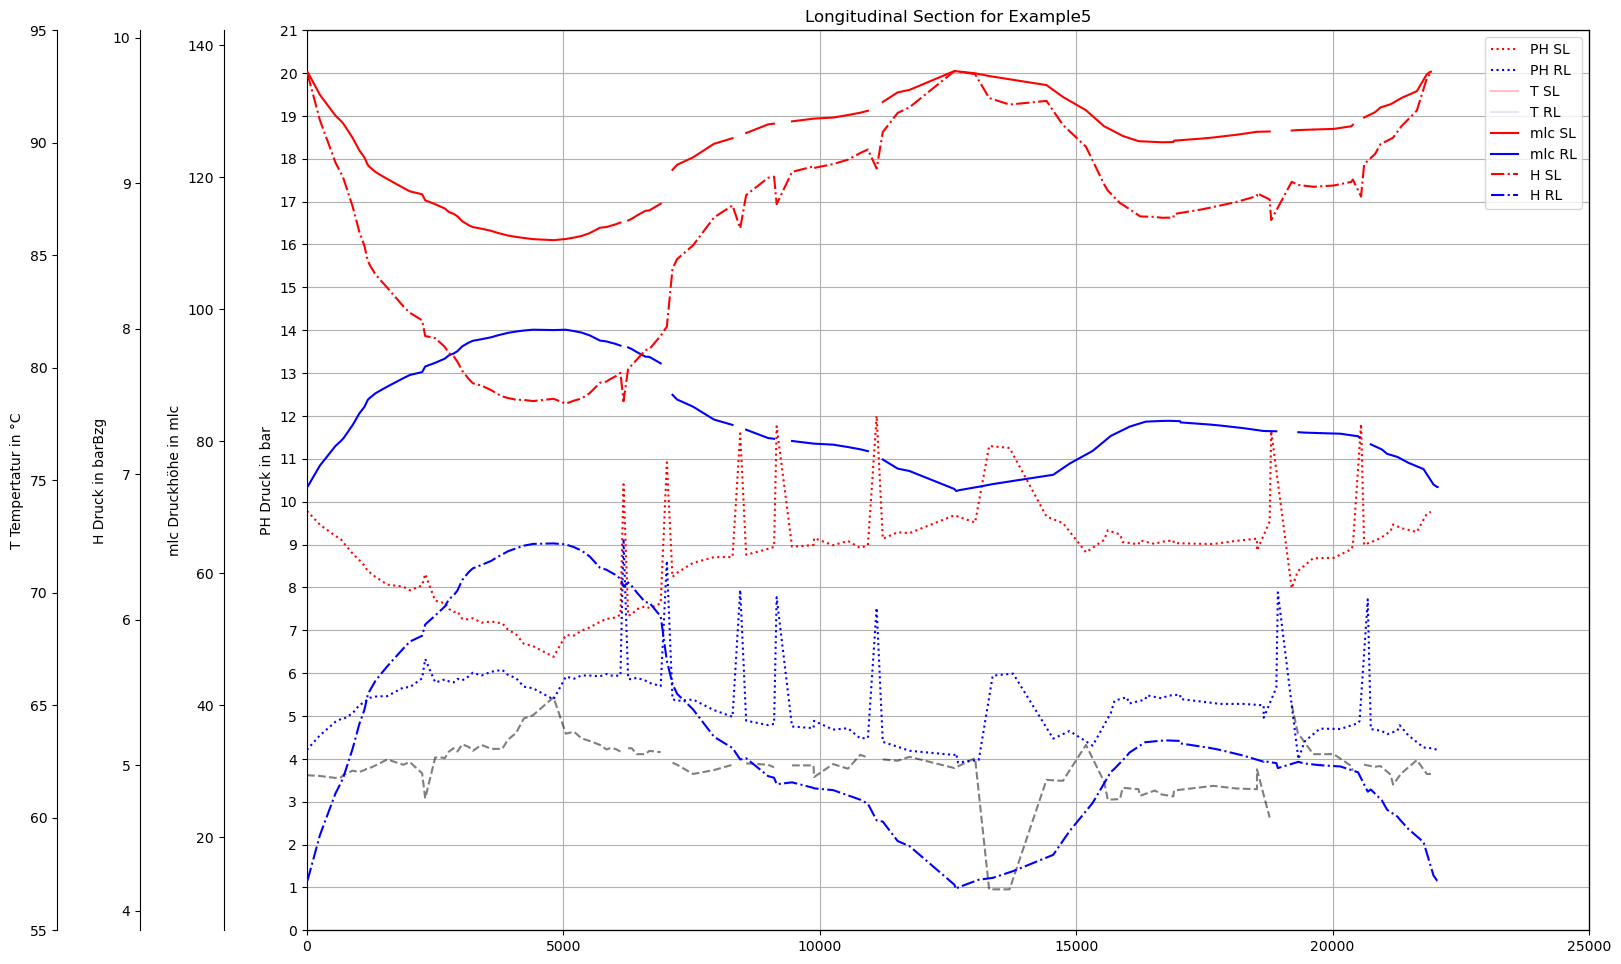

In [13]:
plot_Result_ls(m.V3_AGSN)

# Show Network Graph

In [14]:
netNodes=[n for (n,data) in m.G.nodes(data=True) if data['ID_CONT']==data['IDPARENT_CONT']] # nur das Netz

In [15]:
GNet=m.G.subgraph(netNodes)

In [16]:
nx.number_connected_components(GNet)

1

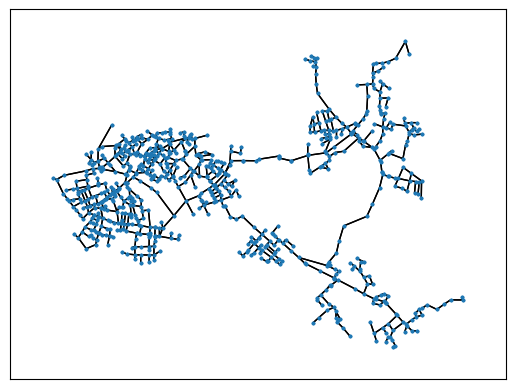

In [17]:
nx.draw_networkx(GNet,with_labels = False,node_size=3,pos=m.nodeposDctNx)

# Decomposition into Areas

In the network, areas can be separated by  valves in the sense of an emergency concept. 
In this way, leaks can be isolated while maintaining supply in the other areas.
All seperating valves are located in the SIR 3S Block "TS".
So the network graph without the content of "TS" must be decomposed into areas.

In [18]:
netEdgesWithoutTS=[(i,k) for i,k,data in GNet.edges(data=True) if data['NAME_CONT'] not in ['TS']] 

In [19]:
GNetWithoutTS=GNet.edge_subgraph(netEdgesWithoutTS)

In [20]:
nOfCC=nx.number_connected_components(GNetWithoutTS)
nOfCC

25

In [21]:
GNetWithoutTSAreas=[GNet.subgraph(c).copy() for c in sorted(nx.connected_components(GNetWithoutTS), key=len, reverse=True)]

# Read SirCalc's XmlFile

In [22]:
import xml.etree.ElementTree as ET
tree = ET.parse(m.SirCalcXmlFile) # ElementTree                 
root = tree.getroot()  # Element

# Loop over all Areas

In [23]:
max_dfAGSN_SL = None
max_dfAGSN_RL = None
min_dfAGSN_SL = None
min_dfAGSN_RL = None
cols_to_track = ['PH_n', 'mlc_n', 'T_n']
V3_AGSN_list = []

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\SIR 3S\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\jablonski\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


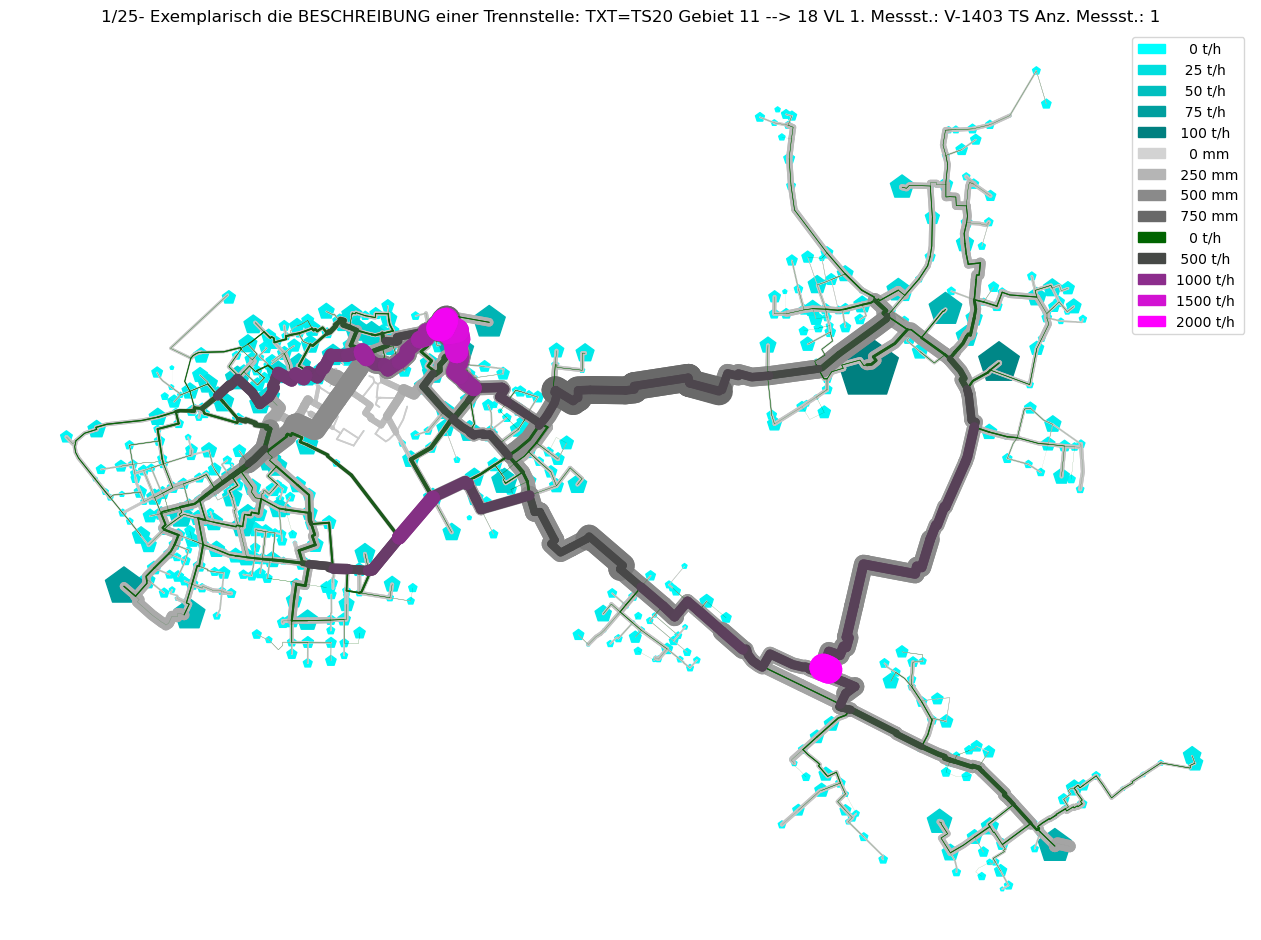

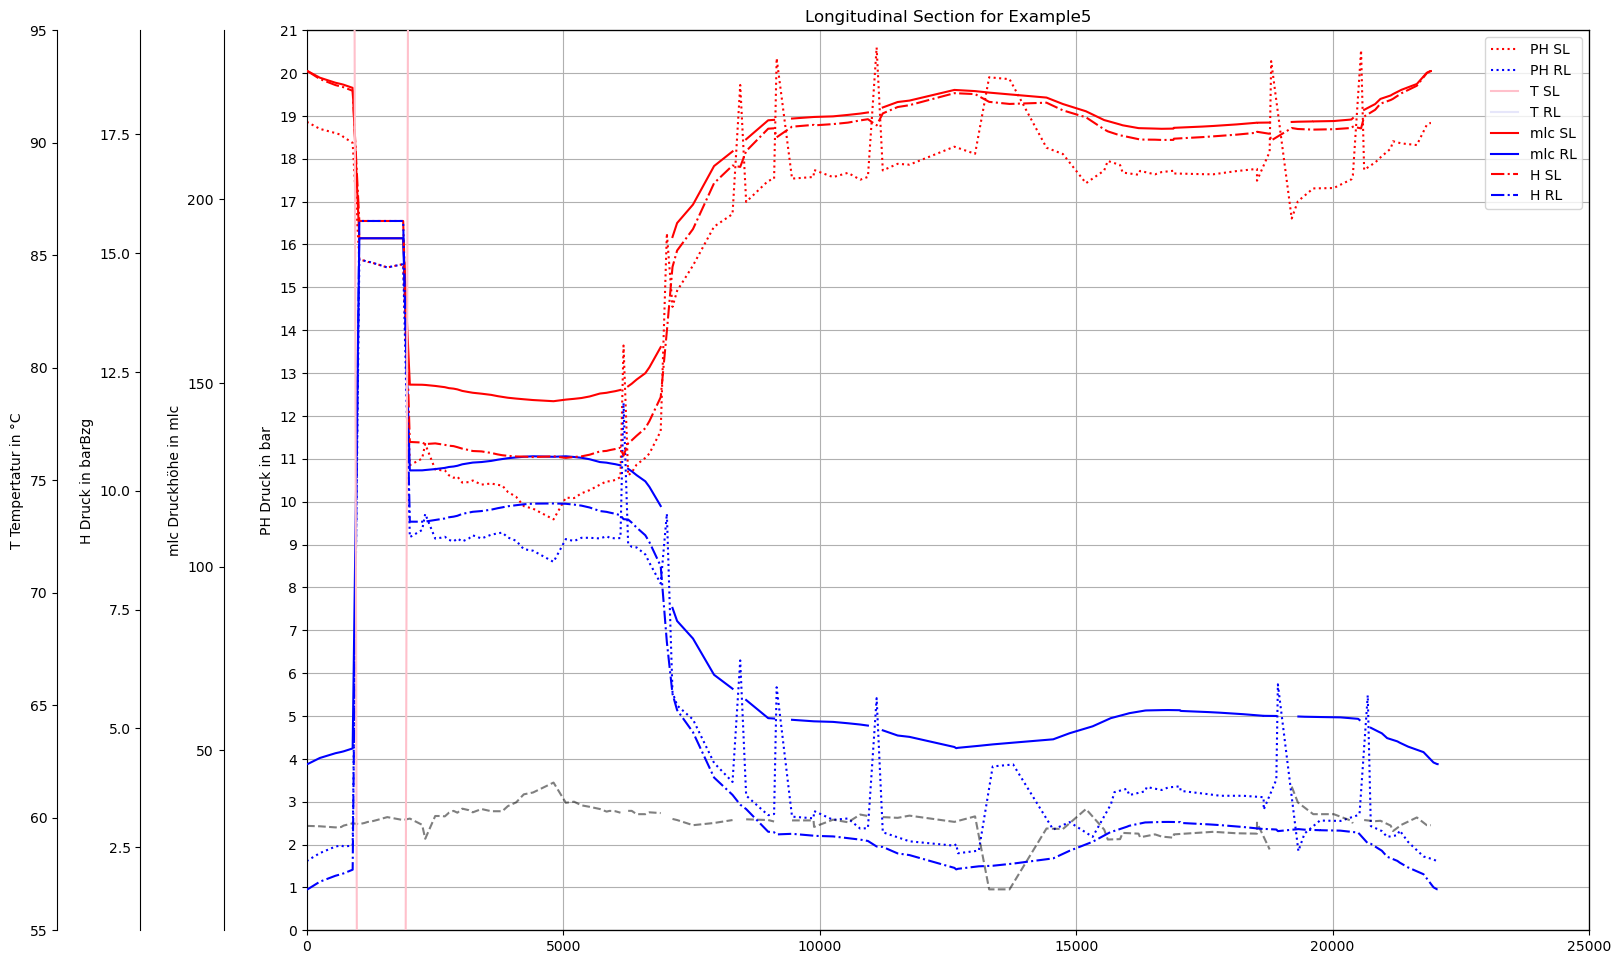

Command ['C:\\\\3S\\SIR 3S\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\jablonski\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


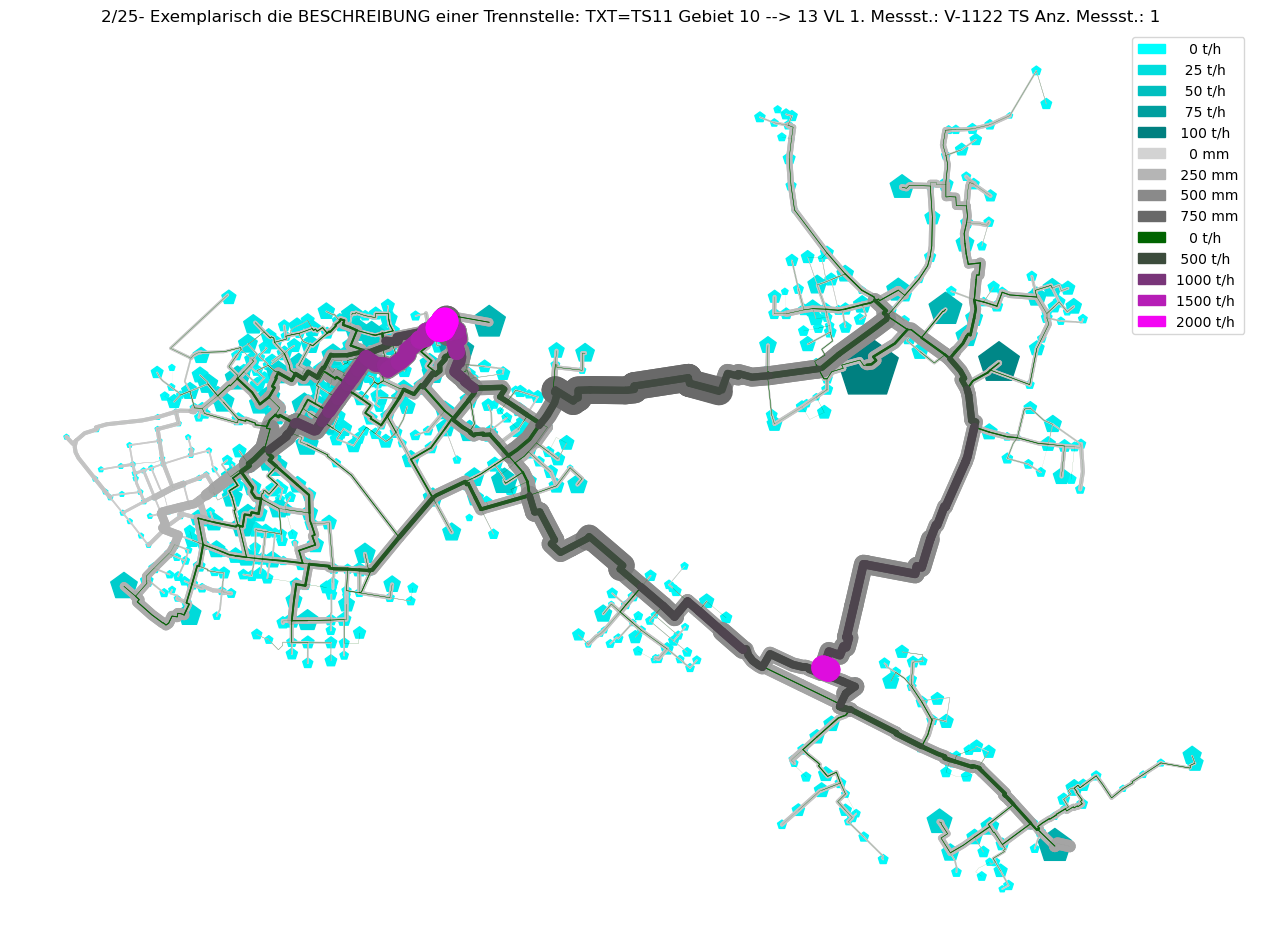

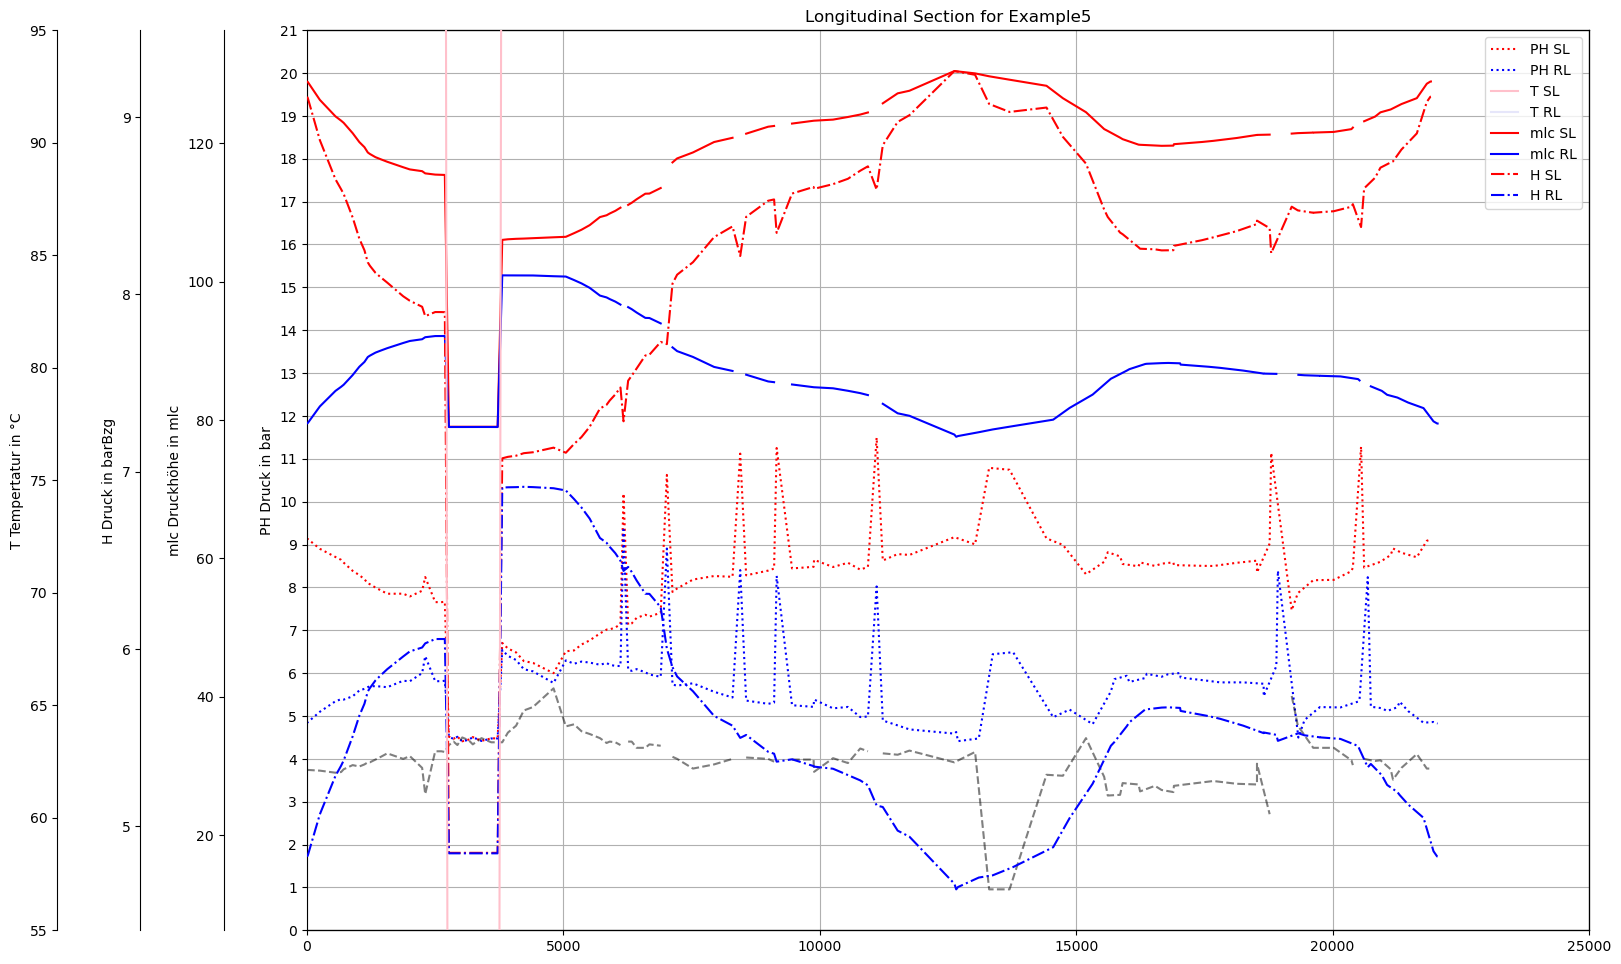

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\SIR 3S\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\jablonski\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


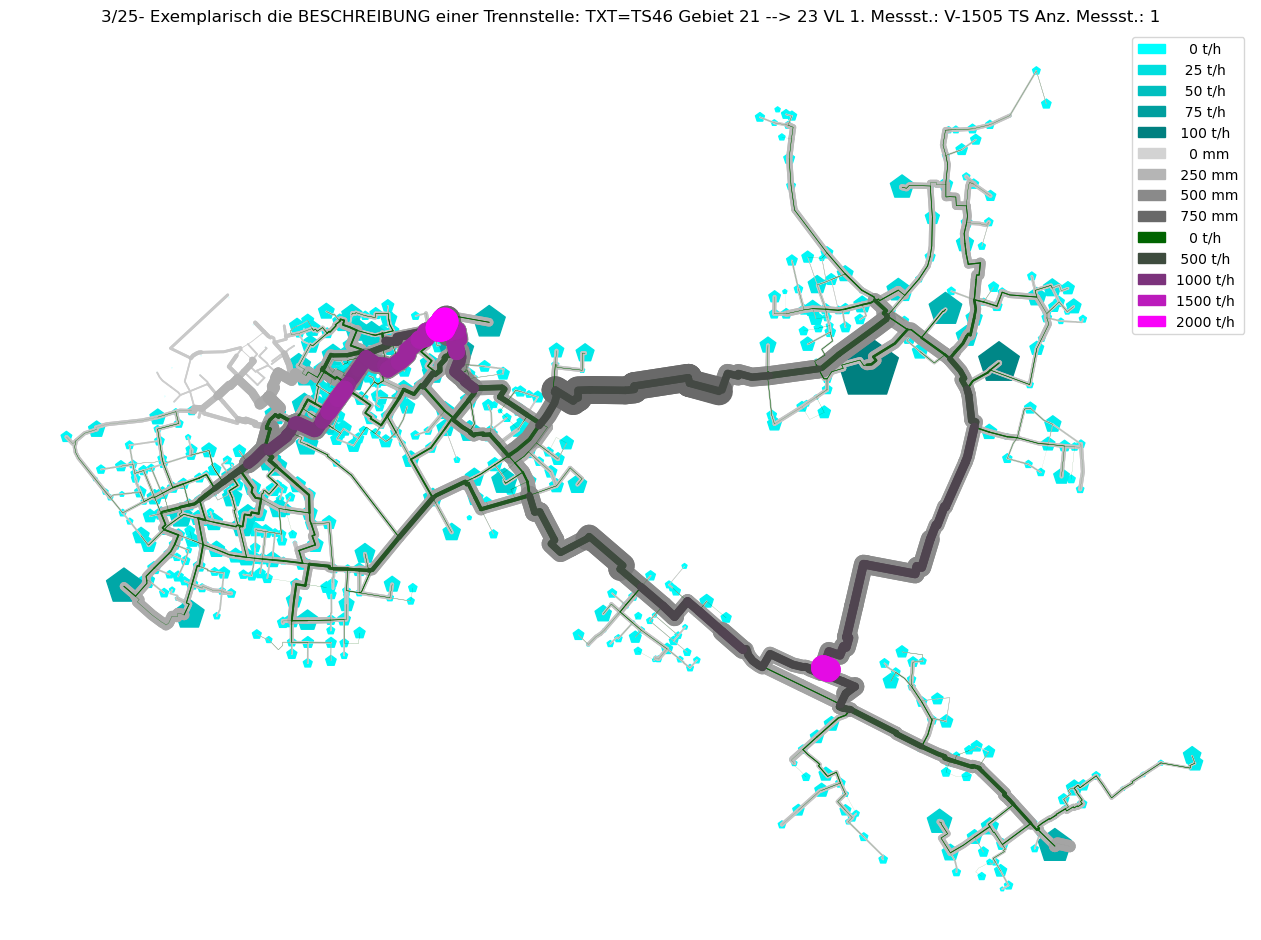

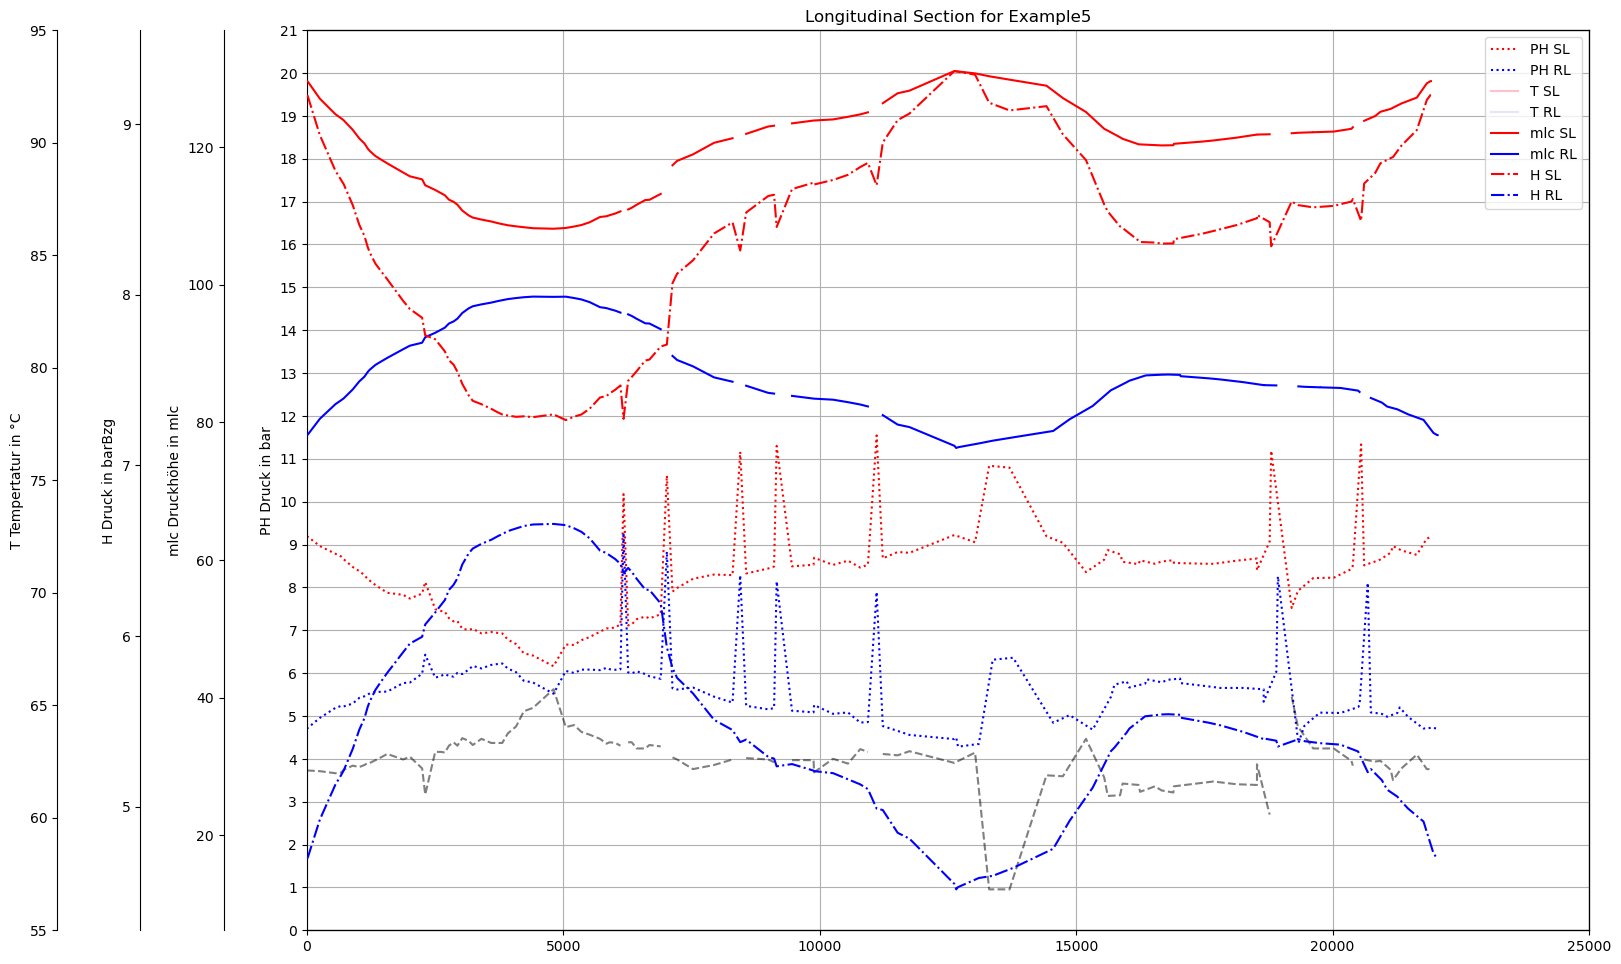

Gebiet um Erzeuger H - keine Trennung


INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\SIR 3S\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\jablonski\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


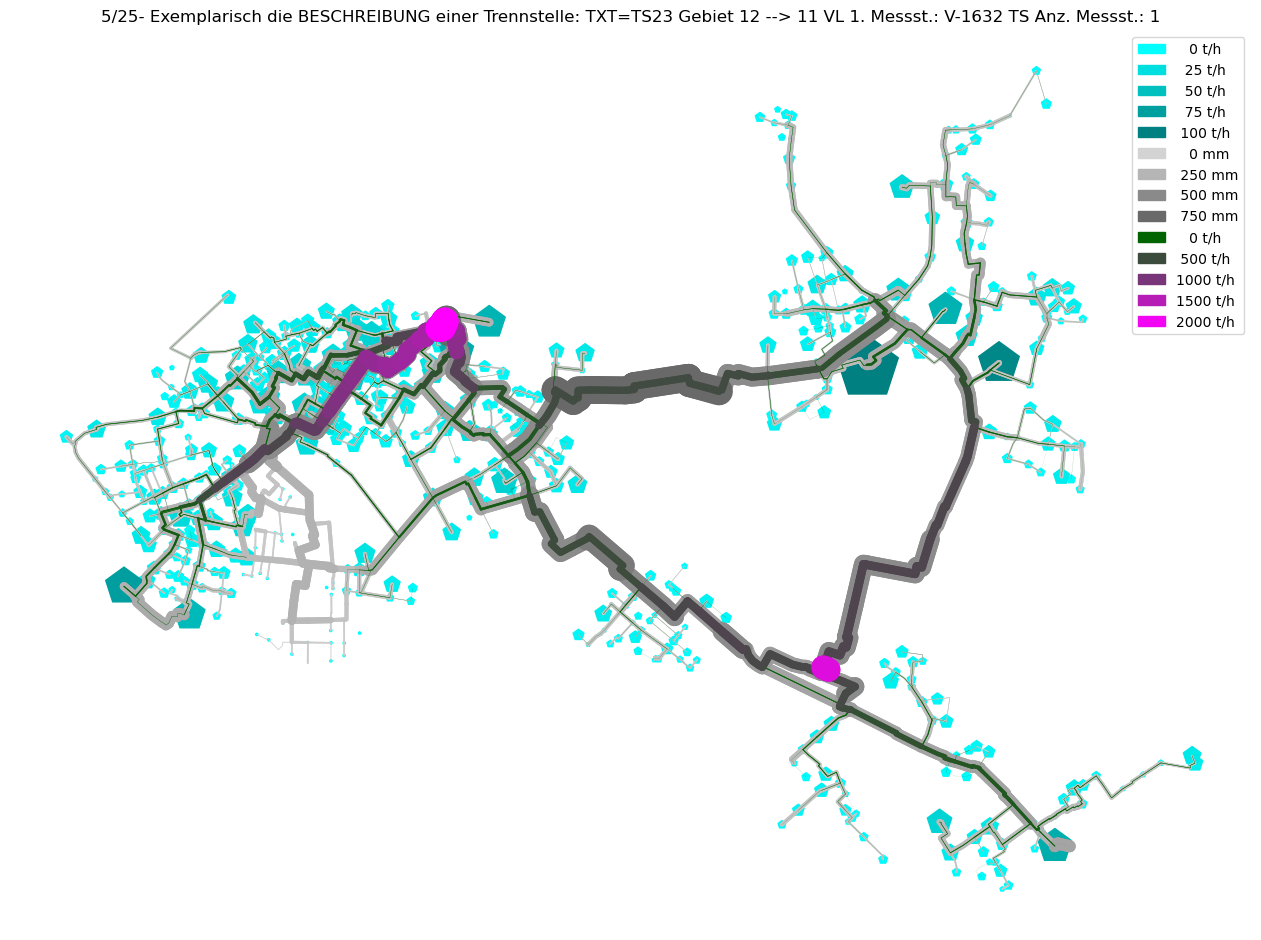

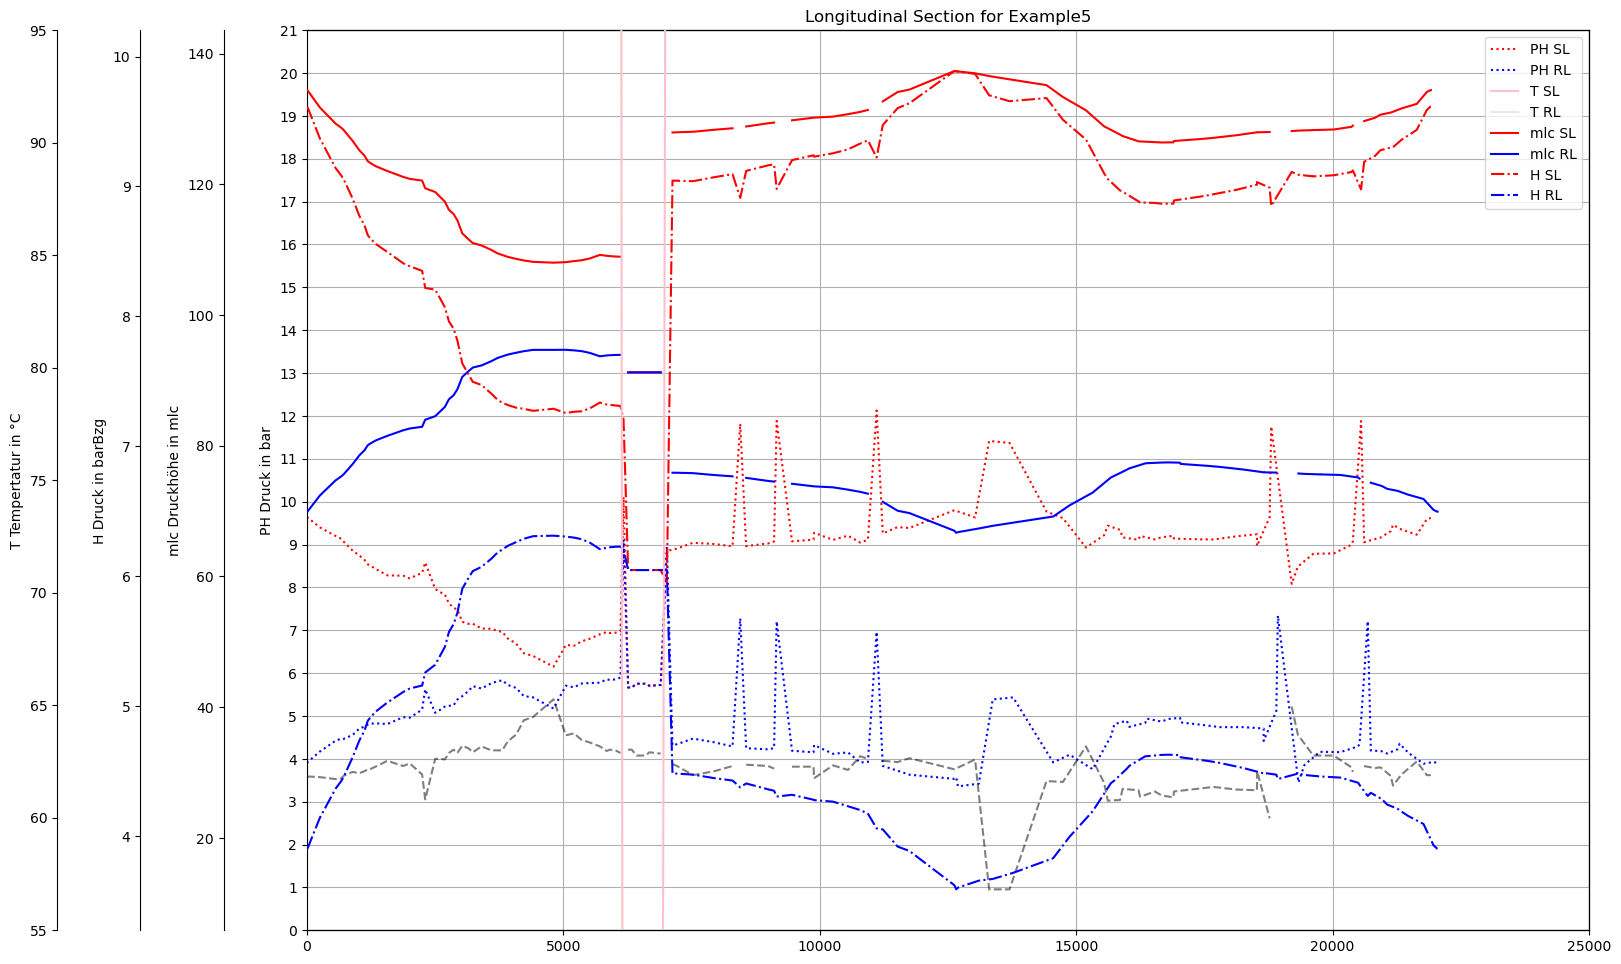

Command ['C:\\\\3S\\SIR 3S\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\jablonski\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


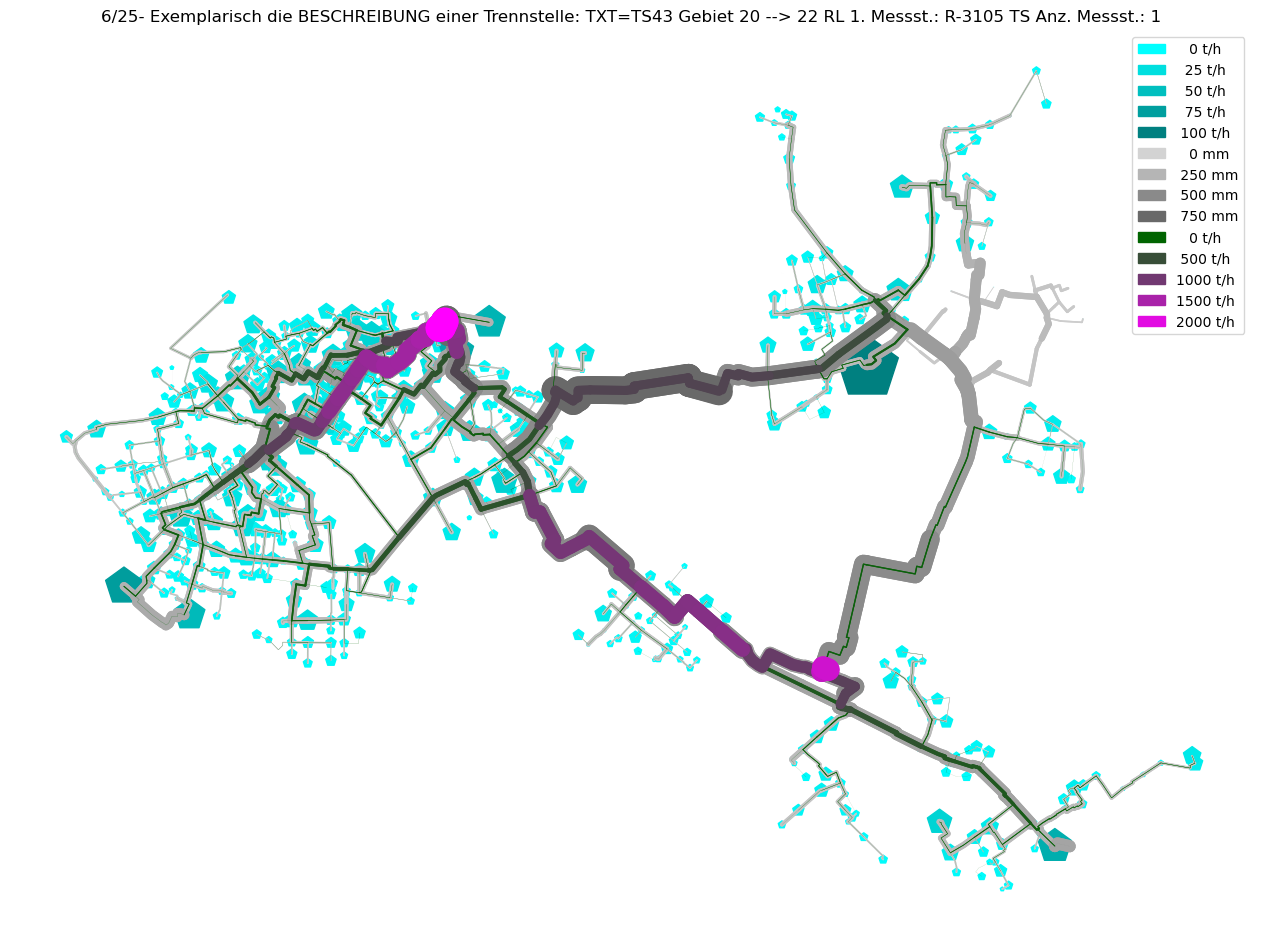

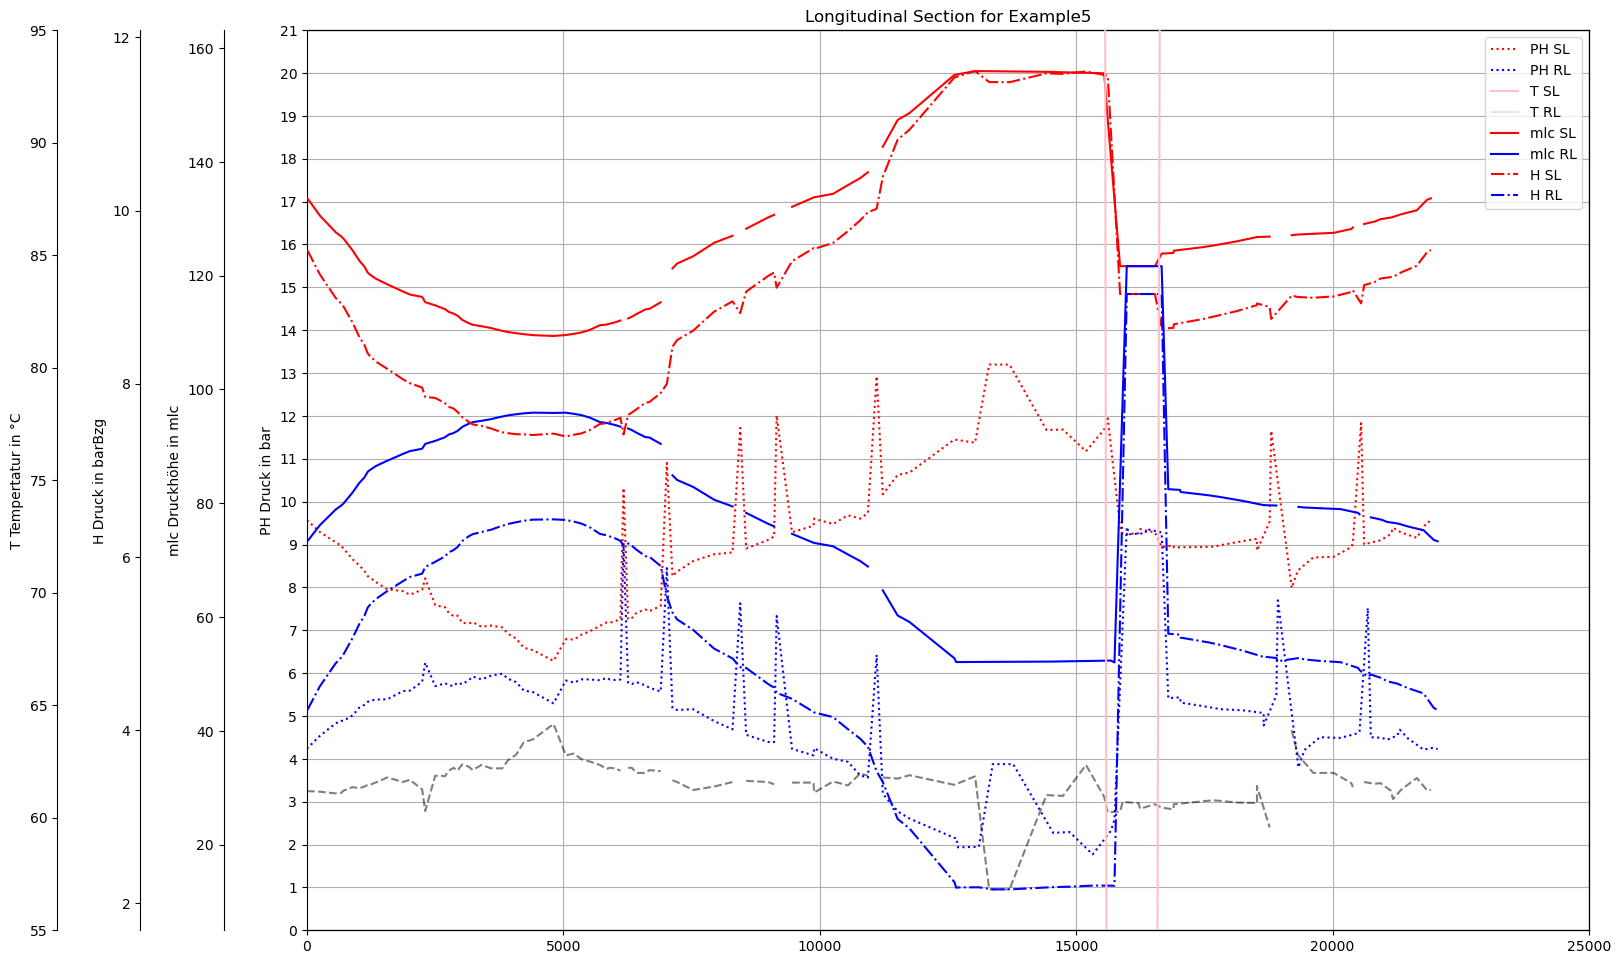

In [24]:
for idx,G in enumerate(GNetWithoutTSAreas):
        
    # Determine seperating Valves to close
    trennNodes=[]
    for n, data in G.nodes(data=True):
        if data['NAME_CONT_VKNO']=='TS':
            trennNodes.append(n)            
    
    trennNodes=sorted(trennNodes)
    
    #print(sorted(G.nodes))
    
    if 'V-A1' in G.nodes:
        print("Gebiet um Erzeuger H - keine Trennung")
        continue
        
    if 'V-A2' in G.nodes:
        print("Gebiet um Erzeuger H - keine Trennung")
        continue
        
    if 'V-B' in G.nodes:
        print("Gebiet um Erzeuger R - keine Trennung")
        continue
    
    
    df=m.V3_VBEL.reset_index()
    
    df=df[
        (
        (df['NAME_i'].isin(trennNodes))        
        | 
        (df['NAME_k'].isin(trennNodes))
        )
        &
        df['OBJTYPE'].isin(['VENT'])
        &
        df['NAME_CONT'].isin(['TS'])
        
    ]
    
    # Close the Valves in SirCalc's Xml 
    for index,row in df.iterrows():
        for el in root.findall('VENT_BZ'):
            if el.attrib['fk']==row['OBJID']:                
                el.set('INDPHI','-1')
                BESCHREIBUNG=row['BESCHREIBUNG']
    tree.write(m.SirCalcXmlFile)
    
    # Calculate 
    with subprocess.Popen([m.SirCalcExeFile
                       ,m.SirCalcXmlFile]                      
                     ) as process:
        process.wait()
        print(f'Command {process.args} exited with {process.returncode}.')
    
    # Ergebnis lesen
    mx=Mx.Mx(m.mx.mx1File)
    mTmp = dxAndMxHelperFcts.dxWithMx(m.dx,mx)

    axTitle=f"{idx+1}/{nOfCC}- Exemplarisch die BESCHREIBUNG einer Trennstelle: {BESCHREIBUNG}"
    plot_index = int(axTitle.split('/')[0])
    V3_AGSN_list.insert(plot_index, mTmp.V3_AGSN.copy())
    
    # Plot Result as ncd
    plot_Result_ncd(mTmp.gdf_ROHR, mTmp.gdf_FWVB,axTitle=axTitle)

    # Plot Result as Longitudinal Sections
    plot_Result_ls(mTmp.V3_AGSN)

    # Update the maximum values DataFrames for SL and RL
    if max_dfAGSN_SL is None:
        max_dfAGSN_SL = mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 1].copy()
        max_dfAGSN_RL = mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 2].copy()
    else:
        for col in cols_to_track:
            max_dfAGSN_SL.loc[max_dfAGSN_SL['XL'] == 1, col] = np.maximum(max_dfAGSN_SL[col], mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 1][col])
            max_dfAGSN_RL.loc[max_dfAGSN_RL['XL'] == 2, col] = np.maximum(max_dfAGSN_RL[col], mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 2][col])
    
    # Update the minimal values DataFrames for SL and RL
    if min_dfAGSN_SL is None:
        min_dfAGSN_SL = mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 1].copy()
        min_dfAGSN_RL = mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 2].copy()
    else:
        for col in cols_to_track:
            min_dfAGSN_SL.loc[min_dfAGSN_SL['XL'] == 1, col] = np.minimum(min_dfAGSN_SL[col], mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 1][col])
            min_dfAGSN_RL.loc[min_dfAGSN_RL['XL'] == 2, col] = np.minimum(min_dfAGSN_RL[col], mTmp.V3_AGSN[mTmp.V3_AGSN['XL'] == 2][col])
    
    # (Re-)Open the Valves in SirCalc's Xml 
    for index,row in df.iterrows():
        for el in root.findall('VENT_BZ'):
            if el.attrib['fk']==row['OBJID']:                
                el.set('INDPHI','0')
                #print(row['BESCHREIBUNG'])
    
    if idx > 4:
        #pass
        break


# Min/Max

In [25]:
def plot_Result_ls_min_max(dfAGSN1, dfAGSN2):
    PHCol = 'PH_n'
    mlcCol = 'mlc_n'
    zKoorCol = 'ZKOR_n'
    barBzgCol = 'H_n'
    QMCol = 'QM'
    TCol = 'T_n'
    xCol = 'LSum'

    # Convert columns to numeric, forcing errors to NaN
    for col in [PHCol, mlcCol, barBzgCol, TCol, xCol]:
        dfAGSN1[col] = pd.to_numeric(dfAGSN1[col], errors='coerce')
        dfAGSN2[col] = pd.to_numeric(dfAGSN2[col], errors='coerce')

    # Create checkboxes for each value pair
    PH_SL_checkbox = widgets.Checkbox(value=True, description='PH SL')
    PH_RL_checkbox = widgets.Checkbox(value=False, description='PH RL')
    mlc_SL_checkbox = widgets.Checkbox(value=False, description='mlc SL')
    mlc_RL_checkbox = widgets.Checkbox(value=False, description='mlc RL')

    def update_plot(PH_SL, PH_RL, mlc_SL, mlc_RL):
        
        fig, ax0 = plt.subplots(figsize=Rm.DINA3q)        
        ax0.grid()

        lns = []

        # Process dfAGSN1
        name_prefix1 = dfAGSN1.name.split('_')[0]
        dfAGSN1_SL = dfAGSN1[(dfAGSN1['LFDNR'] == 1) & (dfAGSN1['XL'] == 1)]
        dfAGSN1_RL = dfAGSN1[(dfAGSN1['LFDNR'] == 1) & (dfAGSN1['XL'] == 2)]

        # Process dfAGSN2
        name_prefix2 = dfAGSN2.name.split('_')[0]
        dfAGSN2_SL = dfAGSN2[(dfAGSN2['LFDNR'] == 1) & (dfAGSN2['XL'] == 1)]
        dfAGSN2_RL = dfAGSN2[(dfAGSN2['LFDNR'] == 1) & (dfAGSN2['XL'] == 2)]

        # Create a dictionary to store axes
        axes_dict = {}

        # Function to get or create an axis
        def get_or_create_axis(ax_key):
            if ax_key not in axes_dict:
                axes_dict[ax_key] = ax0.twinx()
            return axes_dict[ax_key]

        # PH SL
        if PH_SL:
            fyPH(ax0) 
            PH_SL1 = ax0.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[PHCol], label=f'{name_prefix1} PH SL', ls='dotted', color='blue')
            PH_SL2 = ax0.plot(dfAGSN2_SL[xCol], dfAGSN2_SL[PHCol], label=f'{name_prefix2} PH SL', ls='dotted', color='red')
            lns += PH_SL1 + PH_SL2
            ax0.fill_between(dfAGSN1_SL[xCol], dfAGSN1_SL[PHCol], dfAGSN2_SL[PHCol], color='gray', alpha=0.3)
            diff_PH_SL = ax0.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[PHCol] - dfAGSN2_SL[PHCol], label=f'Diff {name_prefix1} - {name_prefix2} PH SL', ls='solid', color='black')
            lns += diff_PH_SL
        
        # PH RL
        if PH_RL:
            fyPH(ax0) 
            PH_RL1 = ax0.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[PHCol], label=f'{name_prefix1} PH RL', ls='dotted', color='blue')
            PH_RL2 = ax0.plot(dfAGSN2_RL[xCol], dfAGSN2_RL[PHCol], label=f'{name_prefix2} PH RL', ls='dotted', color='red')
            lns += PH_RL1 + PH_RL2
            ax0.fill_between(dfAGSN1_RL[xCol], dfAGSN1_RL[PHCol], dfAGSN2_RL[PHCol], color='gray', alpha=0.3)
            diff_PH_RL = ax0.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[PHCol] - dfAGSN2_RL[PHCol], label=f'Diff {name_prefix1} - {name_prefix2} PH RL', ls='solid', color='black')
            lns += diff_PH_RL
        
        # mlc SL
        if mlc_SL:
            ax11 = get_or_create_axis('mlc')     
            fymlc(ax11) 
            mlc_SL1 = ax11.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[mlcCol], label=f'{name_prefix1} mlc SL', ls='--', color='green')
            mlc_SL2 = ax11.plot(dfAGSN2_SL[xCol], dfAGSN2_SL[mlcCol], label=f'{name_prefix2} mlc SL', ls='--', color='orange')
            lns += mlc_SL1 + mlc_SL2
            ax11.fill_between(dfAGSN1_SL[xCol], dfAGSN1_SL[mlcCol], dfAGSN2_SL[mlcCol], color='gray', alpha=0.3)
            diff_mlc_SL = ax11.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[mlcCol] - dfAGSN2_SL[mlcCol], label=f'Diff {name_prefix1} - {name_prefix2} mlc SL', ls='solid', color='black')
            lns += diff_mlc_SL
        
        # mlc RL
        if mlc_RL:
            ax11 = get_or_create_axis('mlc')     
            fymlc(ax11) 
            mlc_RL1 = ax11.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[mlcCol], label=f'{name_prefix1} mlc RL', ls='--', color='green')
            mlc_RL2 = ax11.plot(dfAGSN2_RL[xCol], dfAGSN2_RL[mlcCol], label=f'{name_prefix2} mlc RL', ls='--', color='orange')
            lns += mlc_RL1 + mlc_RL2
            ax11.fill_between(dfAGSN1_RL[xCol], dfAGSN1_RL[mlcCol], dfAGSN2_RL[mlcCol], color='gray', alpha=0.3)
            diff_mlc_RL = ax11.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[mlcCol] - dfAGSN2_RL[mlcCol], label=f'Diff {name_prefix1} - {name_prefix2} mlc RL', ls='solid', color='black')
            lns += diff_mlc_RL
        
        labs = [l.get_label() for l in lns]

        ax0.set_xlim(dfAGSN1['LSum'].min(), 25000)
        
        ax0.legend(lns, labs)
            
        plt.show()

    # Create interactive plot
    interactive_plot = widgets.interactive(update_plot,
                                           PH_SL=PH_SL_checkbox,
                                           PH_RL=PH_RL_checkbox,
                                           mlc_SL=mlc_SL_checkbox,
                                           mlc_RL=mlc_RL_checkbox,)
    
    display(interactive_plot)

In [26]:
max_dfAGSN_SL['XL'] = 1
max_dfAGSN_RL['XL'] = 2
max_dfAGSN = pd.concat([max_dfAGSN_SL, max_dfAGSN_RL])

min_dfAGSN_SL['XL'] = 1
min_dfAGSN_RL['XL'] = 2
min_dfAGSN = pd.concat([min_dfAGSN_SL, min_dfAGSN_RL])

In [27]:
min_dfAGSN.name='min'
max_dfAGSN.name='max'
dfAGSN_list=(min_dfAGSN, max_dfAGSN)
plot_Result_ls_min_max(max_dfAGSN, min_dfAGSN)

interactive(children=(Checkbox(value=True, description='PH SL'), Checkbox(value=False, description='PH RL'), C…

In [28]:
try:
    image = Image(filename=os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))+r"\Examples\Images\5_example5_minmaxplot.png")
    display(image)
except:
    print('png not displayed')

png not displayed


# Difference

In [29]:
def plot_Result_ls_comparison(dfAGSN1, dfAGSN2):
    PHCol = 'PH_n'
    mlcCol = 'mlc_n'
    zKoorCol = 'ZKOR_n'
    barBzgCol = 'H_n'
    QMCol = 'QM'
    TCol = 'T_n'
    xCol = 'LSum'

    # Convert columns to numeric, forcing errors to NaN
    dfAGSN1[PHCol] = pd.to_numeric(dfAGSN1[PHCol], errors='coerce')
    dfAGSN1[mlcCol] = pd.to_numeric(dfAGSN1[mlcCol], errors='coerce')
    dfAGSN1[barBzgCol] = pd.to_numeric(dfAGSN1[barBzgCol], errors='coerce')
    dfAGSN1[TCol] = pd.to_numeric(dfAGSN1[TCol], errors='coerce')
    dfAGSN1[xCol] = pd.to_numeric(dfAGSN1[xCol], errors='coerce')

    dfAGSN2[PHCol] = pd.to_numeric(dfAGSN2[PHCol], errors='coerce')
    dfAGSN2[mlcCol] = pd.to_numeric(dfAGSN2[mlcCol], errors='coerce')
    dfAGSN2[barBzgCol] = pd.to_numeric(dfAGSN2[barBzgCol], errors='coerce')
    dfAGSN2[TCol] = pd.to_numeric(dfAGSN2[TCol], errors='coerce')
    dfAGSN2[xCol] = pd.to_numeric(dfAGSN2[xCol], errors='coerce')

    # Create checkboxes for each value pair
    PH_SL_checkbox = widgets.Checkbox(value=False, description='PH SL')
    PH_RL_checkbox = widgets.Checkbox(value=True, description='PH RL')
    mlc_SL_checkbox = widgets.Checkbox(value=False, description='mlc SL')
    mlc_RL_checkbox = widgets.Checkbox(value=False, description='mlc RL')

    def update_plot(PH_SL, PH_RL, mlc_SL, mlc_RL):
        
        fig, ax0 = plt.subplots(figsize=Rm.DINA3q)   
        ax0.grid()

        lns = []

        # Process dfAGSN1
        name_prefix1 = dfAGSN1.name.split('_')[0]
        dfAGSN1_SL = dfAGSN1[(dfAGSN1['LFDNR'] == 1) & (dfAGSN1['XL'] == 1)]
        dfAGSN1_RL = dfAGSN1[(dfAGSN1['LFDNR'] == 1) & (dfAGSN1['XL'] == 2)]

        # Process dfAGSN2
        name_prefix2 = dfAGSN2.name.split('_')[0]
        dfAGSN2_SL = dfAGSN2[(dfAGSN2['LFDNR'] == 1) & (dfAGSN2['XL'] == 1)]
        dfAGSN2_RL = dfAGSN2[(dfAGSN2['LFDNR'] == 1) & (dfAGSN2['XL'] == 2)]

        # Create a dictionary to store axes
        axes_dict = {}

        # Function to get or create an axis
        def get_or_create_axis(ax_key):
            if ax_key not in axes_dict:
                axes_dict[ax_key] = ax0.twinx()
            return axes_dict[ax_key]

        # PH SL
        if PH_SL:
            fyPH_d(ax0) 
            PH_SL1 = ax0.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[PHCol], label=f'{name_prefix1} PH SL', ls='dotted', color='blue')
            PH_SL2 = ax0.plot(dfAGSN2_SL[xCol], dfAGSN2_SL[PHCol], label=f'{name_prefix2} PH SL', ls='dotted', color='red')
            lns += PH_SL1 + PH_SL2
            ax0.fill_between(dfAGSN1_SL[xCol], dfAGSN1_SL[PHCol], dfAGSN2_SL[PHCol], color='gray', alpha=0.3)
            diff_PH_SL = ax0.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[PHCol] - dfAGSN2_SL[PHCol], label=f'Diff {name_prefix1} - {name_prefix2} PH SL', ls='solid', color='black')
            lns += diff_PH_SL
        
        # PH RL
        if PH_RL:
            fyPH_d(ax0) 
            PH_RL1 = ax0.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[PHCol], label=f'{name_prefix1} PH RL', ls='dotted', color='blue')
            PH_RL2 = ax0.plot(dfAGSN2_RL[xCol], dfAGSN2_RL[PHCol], label=f'{name_prefix2} PH RL', ls='dotted', color='red')
            lns += PH_RL1 + PH_RL2
            ax0.fill_between(dfAGSN1_RL[xCol], dfAGSN1_RL[PHCol], dfAGSN2_RL[PHCol], color='gray', alpha=0.3)
            diff_PH_RL = ax0.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[PHCol] - dfAGSN2_RL[PHCol], label=f'Diff {name_prefix1} - {name_prefix2} PH RL', ls='solid', color='black')
            lns += diff_PH_RL
        
        # mlc SL
        if mlc_SL:
            ax11 = get_or_create_axis('mlc')     
            fymlc(ax11) 
            mlc_SL1 = ax11.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[mlcCol], label=f'{name_prefix1} mlc SL', ls='--', color='green')
            mlc_SL2 = ax11.plot(dfAGSN2_SL[xCol], dfAGSN2_SL[mlcCol], label=f'{name_prefix2} mlc SL', ls='--', color='orange')
            lns += mlc_SL1 + mlc_SL2
            ax11.fill_between(dfAGSN1_SL[xCol], dfAGSN1_SL[mlcCol], dfAGSN2_SL[mlcCol], color='gray', alpha=0.3)
            diff_mlc_SL = ax11.plot(dfAGSN1_SL[xCol], dfAGSN1_SL[mlcCol] - dfAGSN2_SL[mlcCol], label=f'Diff {name_prefix1} - {name_prefix2} mlc SL', ls='solid', color='black')
            lns += diff_mlc_SL
        
        # mlc RL
        if mlc_RL:
            ax11 = get_or_create_axis('mlc')     
            fymlc(ax11) 
            mlc_RL1 = ax11.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[mlcCol], label=f'{name_prefix1} mlc RL', ls='--', color='green')
            mlc_RL2 = ax11.plot(dfAGSN2_RL[xCol], dfAGSN2_RL[mlcCol], label=f'{name_prefix2} mlc RL', ls='--', color='orange')
            lns += mlc_RL1 + mlc_RL2
            ax11.fill_between(dfAGSN1_RL[xCol], dfAGSN1_RL[mlcCol], dfAGSN2_RL[mlcCol], color='gray', alpha=0.3)
            diff_mlc_RL = ax11.plot(dfAGSN1_RL[xCol], dfAGSN1_RL[mlcCol] - dfAGSN2_RL[mlcCol], label=f'Diff {name_prefix1} - {name_prefix2} mlc RL', ls='solid', color='black')
            lns += diff_mlc_RL

        labs = [l.get_label() for l in lns]
        
        ax0.set_xlim(dfAGSN1['LSum'].min(), 25000)
        
        ax0.legend(lns, labs)
            
        plt.show()

    # Create interactive plot
    interactive_plot = widgets.interactive(update_plot,
                                           PH_SL=PH_SL_checkbox,
                                           PH_RL=PH_RL_checkbox,
                                           mlc_SL=mlc_SL_checkbox,
                                           mlc_RL=mlc_RL_checkbox,)
    
    display(interactive_plot)

In [30]:
#Indexing issue - to be fixed (JAB 01/11)
V3_AGSN_list[0].name='1'
V3_AGSN_list[2].name='3'
plot_Result_ls_comparison(V3_AGSN_list[0], V3_AGSN_list[2])

interactive(children=(Checkbox(value=False, description='PH SL'), Checkbox(value=True, description='PH RL'), C…

In [31]:
try:
    image = Image(filename=os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))+r"\Examples\Images\6_example5_differenceplot.png")
    display(image)
except:
    print('png not displayed')

png not displayed


# Recalculate initial condition

In [32]:
# (Re-)Calculate initial condition
tree.write(m.SirCalcXmlFile)
# Calculate 
with subprocess.Popen([m.SirCalcExeFile
                       ,m.SirCalcXmlFile]                      
                     ) as process:
        process.wait()
        print(f'Command {process.args} exited with {process.returncode}.')

Command ['C:\\\\3S\\SIR 3S\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\jablonski\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.
